<a href="https://colab.research.google.com/github/Nendyy/Diabetes_readmission/blob/main/Data_modelling_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA MODELLING**

I am going to build and train 5 models for predicting readmission among diabetic patients. They include;
- `Logistic Regression`
- `XG Boost`
- `Random Forest`
- `Cat Boost`
- `Balanced Bagging`

### **F1 Score as the scoring metric**
`Accuracy` is often a misleading metric for imbalanced datasets, as it measures the proportion of correct predictions overall. In situations where one class is significantly more frequent than the other(s), accuracy does not adequately capture the performance of models on such imbalanced classes. In such cases, a model could achieve high accuracy while performing poorly on minority class predictions.

`Precision` and `Recall` are more appropriate for handling imblanced datasets. Precision focuses on the model's ability to correctly identify positive cases (true positives) out of all instances it predicted as positive. High precision means that when the model predicts a positive case, it is usually correct, which is crucial when false positives are costly (e.g., medical diagnoses).

Recall (or Sensitivity) measures the model's ability to identify all actual positive cases (true positives out of all positive instances). High recall ensures that the model doesn't miss too many actual positive cases, which is important when false negatives are costly (e.g., missing a serious disease).

The `F1 score` is the harmonic mean of precision and recall, and it provides a balance between the two. It is especially useful when there is a trade-off between precision and recall, as it considers both metrics in a single value. The F1 score becomes particularly valuable in imbalanced datasets, where focusing on just precision or recall may give an incomplete picture of model performance.

- High precision but low recall means the model identifies fewer positives but is mostly correct when it does.
- High recall but low precision means the model identifies most positives but also misclassifies many negatives.

The F1 score balances these two, making it an ideal metric for evaluating models in scenarios where both precision and recall are critical and when class imbalance is present.

In [ ]:
!pip install mplcyberpunk

In [33]:
# import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import mplcyberpunk
import plotly.express as px
import plotly.graph_objects as go


plt.style.use("cyberpunk")

# Ignore all warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# import the necessary libraries
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the DataFrame
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final_dataset_.csv')
print(df.shape)
df.head()

(69960, 26)


,race,gender,age,admission_type,discharge_disposition,admission_source,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,HbA1c,metformin,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,readmitted
0,Caucasian,0,[0-40],Other,Other,Physician referral,1,41,0,1,...,-99.0,0,0,0,0,0,No,0,0,0
1,Caucasian,0,[0-40],Emergency,Home,Emergency room,3,59,0,18,...,-99.0,0,0,0,0,0,Up,1,1,0
2,AfricanAmerican,0,[0-40],Emergency,Home,Emergency room,2,11,5,13,...,-99.0,0,1,0,0,0,No,0,1,0
3,Caucasian,1,[0-40],Emergency,Home,Emergency room,2,44,1,16,...,-99.0,0,0,0,0,0,Up,1,1,0
4,Caucasian,1,[40-50],Emergency,Home,Emergency room,1,51,0,8,...,-99.0,0,1,0,0,0,Steady,1,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69960 entries, 0 to 69959
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   race                   69960 non-null  object 
 1   gender                 69960 non-null  int64  
 2   age                    69960 non-null  object 
 3   admission_type         69960 non-null  object 
 4   discharge_disposition  69960 non-null  object 
 5   admission_source       69960 non-null  object 
 6   time_in_hospital       69960 non-null  int64  
 7   num_lab_procedures     69960 non-null  int64  
 8   num_procedures         69960 non-null  int64  
 9   num_medications        69960 non-null  int64  
 10  number_outpatient      69960 non-null  int64  
 11  number_emergency       69960 non-null  int64  
 12  number_inpatient       69960 non-null  int64  
 13  primary_diagnosis      69960 non-null  object 
 14  number_diagnoses       69960 non-null  int64  
 15  ma

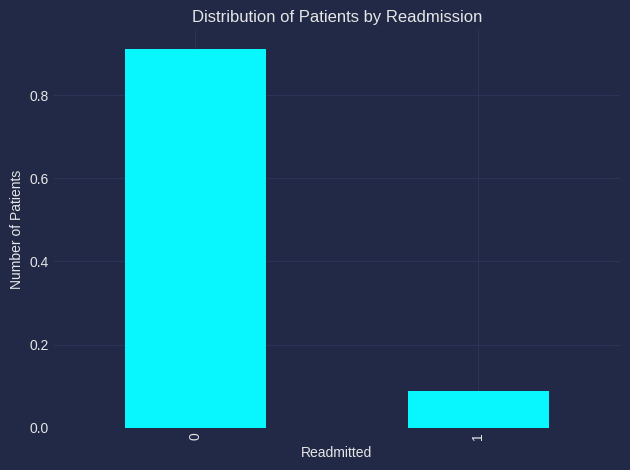

In [11]:
# distribution of readmitted column
df['readmitted'].value_counts(normalize = True).plot(kind='bar')
# labeling the plot
plt.xlabel('Readmitted')
plt.ylabel('Number of Patients')
plt.title('Distribution of Patients by Readmission')
plt.tight_layout();

The readmitted column has imbalanced data with about 90% **'not readmitted'**, and about 10% **'admitted'**. I will have to address the class imbalance.
The main aim is to predict readmission [1] which makes it the 'positive class'.

In [17]:
# Create the feature matrix 'X' and target vector 'y'. The target is "readmitted".
target = "readmitted"
X = df.drop(target, axis=1)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (69960, 25)
y shape: (69960,)


In [18]:
# Divide the data (X and y) into training and test sets using a randomized train-test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (48972, 25)
y_train shape: (48972,)
X_test shape: (20988, 25)
y_test shape: (20988,)


In [19]:
# Divide the data (X_test and y_test) into validation and test sets using a randomized train-test split
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_val shape: (10494, 25)
y_val shape: (10494,)
X_test shape: (10494, 25)
y_test shape: (10494,)


In [20]:
cat_cols = X_train.select_dtypes(include=['object']).columns
num_cols = X_train.select_dtypes(exclude=['object']).columns

binary_cols = [col for col in num_cols if X_train[col].nunique() == 2]
cont_cols = [col for col in num_cols if col not in binary_cols]

print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)
print("Binary columns:", binary_cols)
print("Continuous columns:", cont_cols)

Categorical columns: Index(['race', 'age', 'admission_type', 'discharge_disposition',
       'admission_source', 'primary_diagnosis', 'insulin'],
      dtype='object')
Numerical columns: Index(['gender', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'HbA1c',
       'metformin', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone',
       'change', 'diabetesMed'],
      dtype='object')
Binary columns: ['gender', 'metformin', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'change', 'diabetesMed']
Continuous columns: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'HbA1c']


In [21]:
# Create the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder on the categorical features of the training data
encoder.fit(X_train[cat_cols])

# Transform the categorical features of all datasets
encoded_data_train = encoder.transform(X_train[cat_cols])
encoded_data_val = encoder.transform(X_val[cat_cols])
encoded_data_test = encoder.transform(X_test[cat_cols])

# Get feature names after transformation
encoded_feature_names = encoder.get_feature_names_out(cat_cols)

# Create DataFrames for the encoded data
encoded_df_train = pd.DataFrame(encoded_data_train, columns=encoded_feature_names, index=X_train.index)
encoded_df_val = pd.DataFrame(encoded_data_val, columns=encoded_feature_names, index=X_val.index)
encoded_df_test = pd.DataFrame(encoded_data_test, columns=encoded_feature_names, index=X_test.index)

# Concatenate the encoded DataFrames with the original DataFrames
X_train_preprocessed = pd.concat([X_train.drop(columns=cat_cols), encoded_df_train], axis=1)
X_val_preprocessed = pd.concat([X_val.drop(columns=cat_cols), encoded_df_val], axis=1)
X_test_preprocessed = pd.concat([X_test.drop(columns=cat_cols), encoded_df_test], axis=1)

X_train_preprocessed

,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,...,primary_diagnosis_Genitourinary,primary_diagnosis_Injury,primary_diagnosis_Musculoskeletal,primary_diagnosis_Neoplasms,primary_diagnosis_Other,primary_diagnosis_Respiratory,insulin_Down,insulin_No,insulin_Steady,insulin_Up
68186,0,4,73,3,24,0,0,0,9,-99.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25233,0,2,44,0,9,0,0,0,8,-99.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
43143,0,6,57,0,17,0,0,0,9,-99.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
65376,0,3,48,0,8,0,0,0,5,-99.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
22911,0,3,44,1,12,0,0,0,5,-99.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,0,2,74,5,9,0,1,1,9,-99.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
45891,1,1,28,1,21,0,0,0,5,-99.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
42613,0,1,19,0,7,0,0,0,5,-99.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
43567,0,8,35,4,19,0,0,0,9,-99.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# Step 2: Apply SMOTENC on the preprocessed data
# Use the index of categorical columns post-OneHotEncoding
# The `categorical_features` should align with the OneHotEncoded indices
#smote_nc = SMOTENC(categorical_features=[i for i in range(len(cat_cols))], random_state=42)

In [ ]:
# Apply SMOTE
#X_train_smote, y_train_smote = smote_nc.fit_resample(X_train_preprocessed, y_train)

I initially applied SMOTE to balance the classes in my dataset. However, I noticed that during training, the models overfit on the training data, leading to poor performance on the validation set. As a result, I decided not to use SMOTE for class balancing. Instead, I will implement class weights to ensure the models assign equal importance to both classes during training.

### Training the `XG Boost` model.
I am going to use Optuna for hyperparameter tuning because it is faster.

In [ ]:
!pip install optuna==4.0.0

In [ ]:
import optuna

In [23]:
# Function to sanitize feature names after OHE
'''
This sanitisation is done because the feature names from the OneHotEncoder include characters
like brackets ([, ]), which XGBoost does not accept. The sanitisation is done to remove such characters.
'''
def sanitize_feature_names(X):
    X.columns = X.columns.str.replace(r'[\[\]<]', '', regex=True)
    return X

In [24]:
# Sanitize feature names before training
X_train_san = sanitize_feature_names(X_train_preprocessed.copy())
X_val_san = sanitize_feature_names(X_val_preprocessed.copy())
#X_test_san = sanitize_feature_names(X_test_preprocessed.copy())

X_train_san.head()

,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,...,primary_diagnosis_Genitourinary,primary_diagnosis_Injury,primary_diagnosis_Musculoskeletal,primary_diagnosis_Neoplasms,primary_diagnosis_Other,primary_diagnosis_Respiratory,insulin_Down,insulin_No,insulin_Steady,insulin_Up
68186,0,4,73,3,24,0,0,0,9,-99.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
25233,0,2,44,0,9,0,0,0,8,-99.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
43143,0,6,57,0,17,0,0,0,9,-99.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
65376,0,3,48,0,8,0,0,0,5,-99.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
22911,0,3,44,1,12,0,0,0,5,-99.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Get the weight for the positive class
scale_pos_weight = class_weights[1] / class_weights[0]

In [ ]:
# Define the objective function
def objective(trial):
    # selected hyperparameters for the XGBoost model
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)


    # Instantiate the model
    xgb_classifier = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=21)

    # Evaluate using cross-validation
    scores = cross_val_score(xgb_classifier, X_train_san, y_train,
                             scoring='f1', cv=5, n_jobs=-1, verbose=1)
    return np.mean(scores)

In [ ]:
# Create the optuna study and optimize
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective, n_trials=50)

[I 2024-09-24 20:40:55,977] A new study created in memory with name: no-name-2afbaf51-0c95-4893-9829-970cf68db790
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.9s finished
[I 2024-09-24 20:41:07,003] Trial 0 finished with value: 0.20802585448109215 and parameters: {'n_estimators': 146, 'max_depth': 8, 'learning_rate': 0.07528175669328141}. Best is trial 0 with value: 0.20802585448109215.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
[I 2024-09-24 20:41:09,986] Trial 1 finished with value: 0.19618165509512525 and parameters: {'n_estimators': 52, 'max_depth': 7, 'learning_rate': 0.29575358095083737}. Best is trial 0 with value: 0.20802585448109215.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished
[I 2024-

In [ ]:
# Print the best hyperparameters and score
print(f"Best hyperparameters: {study_xgb.best_params}")
print(f"Best score: {study_xgb.best_value}")

Best hyperparameters: {'n_estimators': 82, 'max_depth': 4, 'learning_rate': 0.02313730966875507}
Best score: 0.22460571572386576


In [ ]:
# Extract the best hyperparameters
best_params_xgb = study_xgb.best_params

# Instantiate the model
XGB_model = XGBClassifier(
            n_estimators=best_params_xgb['n_estimators'],
            max_depth=best_params_xgb['max_depth'],
            learning_rate=best_params_xgb['learning_rate'],
            scale_pos_weight=scale_pos_weight,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42)

In [ ]:
# Fit the model on the training data
XGB_model.fit(X_train_san, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.02313730966875507, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=82, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [25]:
# Make predictions
y_pred_xgb = XGB_model.predict(X_val_san)
y_pred_proba_xgb = XGB_model.predict_proba(X_val_san)[:, 1]

In [26]:
# Print classification report
print("Classification Report XG Boost:")
print(classification_report(y_val, y_pred_xgb))

Classification Report XG Boost:
              precision    recall  f1-score   support

           0       0.94      0.69      0.79      9593
           1       0.13      0.50      0.21       901

    accuracy                           0.67     10494
   macro avg       0.53      0.59      0.50     10494
weighted avg       0.87      0.67      0.74     10494



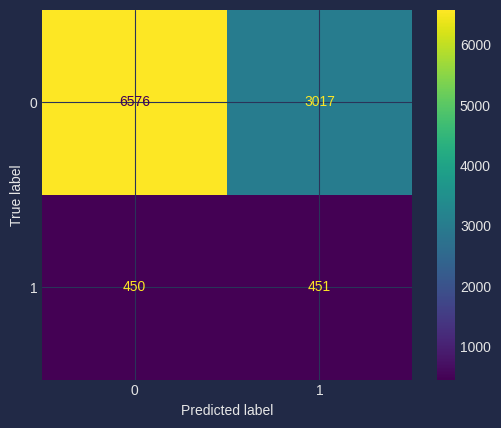

In [32]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(XGB_model, X_val_san, y_val);

In [ ]:
# Save the model to Drive
filename = '/content/drive/MyDrive/xgboost_model.joblib'
joblib.dump(XGB_model, open(filename, 'wb'))

**XGBoost Classification Report Summary**

The XGBoost model shows a weighted accuracy of 67% across the entire dataset. However, let's focus on its performance on the positive class (Class 1), which represents patients who were readmitted.

> Precision for Class 1 (readmission): `0.13`

This indicates that out of all patients predicted as readmitted, only 13% were actually readmitted. The model struggles with correctly identifying readmitted patients.

> Recall for Class 1: `0.50`

The recall shows that the model correctly identifies 50% of actual readmissions, meaning it misses half of the readmission cases.

> F1-Score for Class 1: `0.21`

The F1-score, which balances precision and recall, is quite low for the positive class, reflecting poor overall performance in identifying readmitted patients.

In contrast, the model performs well on the negative class (non-readmission) with high precision (0.94), and reasonable recall (0.69). However, the imbalance in performance across the two classes highlights a significant issue with the model’s ability to accurately predict readmissions.

### Training the `Logistic Regressor`

### Hyperparameter Tuning with GridSearchCV

To optimize the performance of the model, I employed **GridSearchCV** for hyperparameter tuning. This method systematically tests different combinations of hyperparameters to find the best-performing model configuration.

The key benefits of using GridSearchCV include:
- Exhaustive Search: It evaluates all combinations in the parameter grid, ensuring that the best possible hyperparameters are found.
- Cross-Validation: It uses cross-validation to prevent overfitting by evaluating model performance on different subsets of the data.
- Flexible Scoring: I used the **F1-score** as the scoring metric, prioritizing a balance between precision and recall for this classification task.

Although GridSearchCV can be computationally expensive, it was well-suited to this project due to its comprehensive nature and the manageable size of the dataset.


In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga']
}

In [ ]:
# Instantiate the model
log_reg =  LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

In [ ]:
#Set up GridSearchCV
logistic_regressor = GridSearchCV(log_reg, param_grid = param_grid,
                                           scoring= 'f1', cv=5, verbose=1, n_jobs=1)

# Fit the model with the best hyperparameters
logistic_regressor.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=42),
             n_jobs=1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['liblinear', 'saga']},
             scoring='f1', verbose=1)

In [ ]:
# Output the best parameters and score
print("Best Parameters:", logistic_regressor.best_params_)
print("Best Cross-Validation Score:", logistic_regressor.best_score_)

Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Score: 0.222600665180273


In [34]:
# Make predictions
y_pred_lr = logistic_regressor.predict(X_val_preprocessed)
y_pred_proba_lr = logistic_regressor.predict_proba(X_val_preprocessed)[:, 1]

In [35]:
# Print classification report
print("Classification Report Logistic regression:")
print(classification_report(y_val, y_pred_lr))

Classification Report Logistic regression:
              precision    recall  f1-score   support

           0       0.94      0.68      0.79      9593
           1       0.13      0.50      0.20       901

    accuracy                           0.66     10494
   macro avg       0.53      0.59      0.50     10494
weighted avg       0.87      0.66      0.74     10494



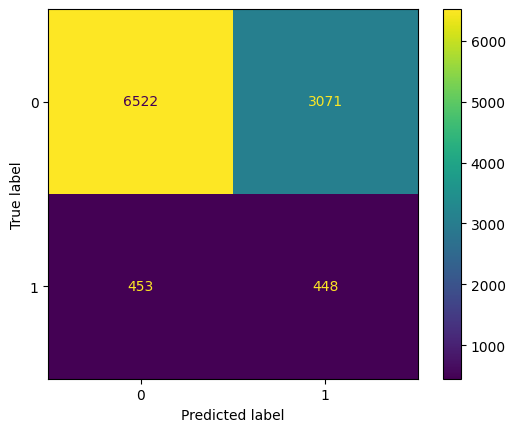

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(logistic_regressor, X_val_preprocessed, y_val);

In [ ]:
# Save the model to drive
filename = '/content/drive/MyDrive/log_reg_model.joblib'
joblib.dump(logistic_regressor, open(filename, 'wb'))

The Logistic regressor model shows a weighted accuracy of 66% across the entire dataset, almost similar to the XG Boost model. Focusing on the performance on the positive class (Class 1), which represents patients who were readmitted:

> Precision for Class 1 (readmission): `0.13`

This indicates that out of all patients predicted as readmitted, only 13% were actually readmitted. The model struggles with correctly identifying readmitted patients.

> Recall for Class 1: `0.50`

The recall shows that the model correctly identifies 50% of actual readmissions, meaning it misses half of the readmission cases.

> F1-Score for Class 1: `0.20`

The F1-score, which balances precision and recall, is quite low for the positive class, reflecting poor overall performance in identifying readmitted patients.

The Logisitic regressor and the XG Boost models have similar performance for both classes, with both models struggling with correctly predicting readmissions (Class 1).

### Training the `Random Forest` model

Hyperparameter tuning will be done with Grid search cv as well

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': range(50, 210, 50),
    'max_depth': range(10, 55, 10),
    'min_samples_split': [2, 5, 10],
}

In [ ]:
Rf_classifier = RandomForestClassifier(class_weight='balanced',
                                       random_state=42)

In [ ]:
# Set up GridSearchCV
rf_model = GridSearchCV(Rf_classifier, param_grid=param_grid,
                        scoring='f1', cv=5, verbose=1, n_jobs=-1)

# Fit the model with the best hyperparameters
rf_model.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': range(10, 55, 10),
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': range(50, 210, 50)},
             scoring='f1', verbose=1)

In [ ]:
# Output the best parameters and score
print("Best Parameters:", rf_model.best_params_)
print("Best Cross-Validation Score:", rf_model.best_score_)

Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-Validation Score: 0.2253851784086196


In [36]:
# Make predictions
y_pred_rf = rf_model.predict(X_val_preprocessed)
y_pred_proba_rf = rf_model.predict_proba(X_val_preprocessed)[:, 1]

In [37]:
# Print classification report
print("Classification Report Random Forest:")
print(classification_report(y_val, y_pred_rf))

Classification Report Random Forest:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85      9593
           1       0.14      0.40      0.21       901

    accuracy                           0.75     10494
   macro avg       0.54      0.59      0.53     10494
weighted avg       0.86      0.75      0.79     10494



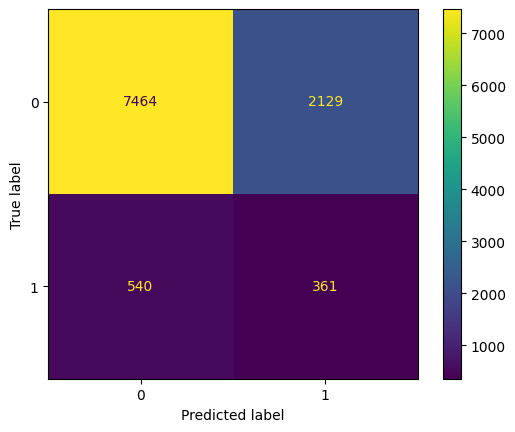

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(rf_model, X_val_preprocessed, y_val);

The performance for predicting readmissions (**Class 1**) remains suboptimal in the Random Forest model:
- **Precision**: `0.14`  
  This means that out of all the instances the model predicted as readmissions, only 14% were correct, indicating a high number of false positives.
  
- **Recall**: `0.40`  
  The model correctly identified 40% of actual readmissions, which shows a modest improvement over its precision but still highlights the model's difficulty in catching all true readmission cases. it also has a lower recall compared to Logistic regression and XG boost, but this is normally the trade-off between precision and recall.

- **F1-score**: `0.21`  
  The F1-score, which balances precision and recall, remains low, further demonstrating the model’s struggle in effectively predicting readmissions.

In comparison to logistic regression and XGBoost, the recall for readmissions in Random Forest is slightly lower (0.40 vs. 0.50), though the precision remains the same across all models (0.13-0.14). While this shows a minor improvement in terms of precision, the overall prediction power for readmissions is still weak.


In [ ]:
# Save the model to drive
filename = '/content/drive/MyDrive/RF_model.joblib'
joblib.dump(rf_model, open(filename, 'wb'))

### Training the `Catboost` model.

Hyperparameter tuning will be done with optuna.

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

In [ ]:
def objective_cat(trial):
    # Suggest hyperparameters for the CatBoost model
    iterations = trial.suggest_int('iterations', 500, 2000)
    depth = trial.suggest_int('depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True)

    # Instantiate the CatBoost model
    catboost_classifier = CatBoostClassifier(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        scale_pos_weight=scale_pos_weight,
        loss_function='Logloss',
        verbose=10,
        random_seed=42
    )

    # Evaluate using cross-validation
    scores = cross_val_score(catboost_classifier, X_train_preprocessed, y_train,
                             scoring='f1', cv=5, n_jobs=-1, verbose=10)
    return np.mean(scores)

In [ ]:
# Run Optuna study
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=100)

[I 2024-09-30 14:07:02,697] A new study created in memory with name: no-name-0a311a43-8ede-4b14-b199-b730415b1b06
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   42.6s remaining:   28.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.7s finished
[I 2024-09-30 14:07:56,497] Trial 0 finished with value: 0.21520773503898605 and parameters: {'iterations': 720, 'depth': 4, 'learning_rate': 0.07561879344542176, 'l2_leaf_reg': 0.005570289694889023}. Best is trial 0 with value: 0.21520773503898605.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   38.8s remaining:   25.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.0s finished
[I 2024-09-30 14:08:45,655] Trial 1 finished with value:

In [ ]:
# Print the best hyperparameters and score
print(f"Best hyperparameters: {study_cat.best_params}")
print(f"Best score: {study_cat.best_value}")

Best hyperparameters: {'iterations': 575, 'depth': 5, 'learning_rate': 0.010325939110844317, 'l2_leaf_reg': 0.0019872300473995964}
Best score: 0.226100908108326


In [ ]:
# Extract the best hyperparameters
best_params_cat = study_cat.best_params

# Create a CatBoost model
cat_model = CatBoostClassifier(
        iterations=best_params_cat['iterations'],
        depth=best_params_cat['depth'],
        learning_rate=best_params_cat['learning_rate'],
        l2_leaf_reg=best_params_cat['l2_leaf_reg'],
        scale_pos_weight=scale_pos_weight,
        loss_function='Logloss',
        verbose=1,
        random_seed=42
    )

In [ ]:
# Fit the model on the training data
cat_model.fit(X_train_preprocessed, y_train)

0:	learn: 0.6926050	total: 15.2ms	remaining: 8.7s
1:	learn: 0.6920375	total: 27.6ms	remaining: 7.92s
2:	learn: 0.6915155	total: 39.4ms	remaining: 7.52s
3:	learn: 0.6910097	total: 50.8ms	remaining: 7.25s
4:	learn: 0.6905216	total: 64ms	remaining: 7.3s
5:	learn: 0.6902561	total: 72.4ms	remaining: 6.87s
6:	learn: 0.6897607	total: 85ms	remaining: 6.9s
7:	learn: 0.6893680	total: 95ms	remaining: 6.73s
8:	learn: 0.6889368	total: 107ms	remaining: 6.72s
9:	learn: 0.6885338	total: 118ms	remaining: 6.65s
10:	learn: 0.6880924	total: 130ms	remaining: 6.66s
11:	learn: 0.6877136	total: 144ms	remaining: 6.75s
12:	learn: 0.6873136	total: 159ms	remaining: 6.86s
13:	learn: 0.6868627	total: 174ms	remaining: 6.97s
14:	learn: 0.6864508	total: 186ms	remaining: 6.95s
15:	learn: 0.6860664	total: 198ms	remaining: 6.92s
16:	learn: 0.6856573	total: 210ms	remaining: 6.91s
17:	learn: 0.6852864	total: 226ms	remaining: 6.99s
18:	learn: 0.6849166	total: 238ms	remaining: 6.98s
19:	learn: 0.6845063	total: 254ms	remainin

In [38]:
# Make predictions
y_pred_cat = cat_model.predict(X_val_preprocessed)
y_pred_proba_cat = cat_model.predict_proba(X_val_preprocessed)[:, 1]

In [39]:
#Print classification report
print("Classification Report Catboost model:")
print(classification_report(y_val, y_pred_cat))

Classification Report Catboost model:
              precision    recall  f1-score   support

           0       0.94      0.68      0.79      9593
           1       0.13      0.50      0.20       901

    accuracy                           0.66     10494
   macro avg       0.53      0.59      0.50     10494
weighted avg       0.87      0.66      0.74     10494



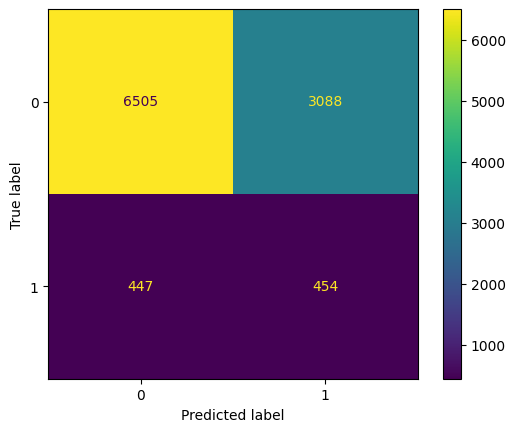

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(cat_model, X_val_preprocessed, y_val);

In comparison to other models like **Logistic Regression** and **XGBoost**, the performance for readmissions (Class 1) for **Catboost** is quite similar. Precision remains consistently low at `0.13`, and recall stands at `0.50`, but the overall F1-score is comparable across models, indicating a shared difficulty in predicting readmissions.

In [ ]:
# Save the model to drive
filename = '/content/drive/MyDrive/cat_model.joblib'
joblib.dump(cat_model, open(filename, 'wb'))

### Train the `Balanced-Bagging` model

The pre-trained Logistic Regressor will be used as the estimator for this model. Balanced Bagging is a bagging-based classifier specifically designed to handle imbalanced datasets. It employs resampling techniques such as oversampling to balance the classes, improving model performance on minority class predictions.


In [ ]:
# Initialize BalancedBaggingClassifier
bagging_model = BalancedBaggingClassifier(
    estimator= logistic_regressor,
    random_state=42
)

# Train the model
bagging_model.fit(X_train_preprocessed, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


BalancedBaggingClassifier(estimator=GridSearchCV(cv=5,
                                                 estimator=LogisticRegression(class_weight='balanced',
                                                                              max_iter=1000,
                                                                              random_state=42),
                                                 n_jobs=1,
                                                 param_grid={'C': [0.001, 0.01,
                                                                   0.1, 1, 10,
                                                                   100],
                                                             'penalty': ['l1',
                                                                         'l2',
                                                                         'elasticnet'],
                                                             'solver': ['liblinear',
                                                                        'saga']},
                                                 scoring='f1', verbose=1),
                          random_state=42)

In [40]:
# Make predictions
y_pred_bag = bagging_model.predict(X_val_preprocessed)
y_pred_proba_bag = bagging_model.predict_proba(X_val_preprocessed)[:, 1]

In [41]:
# Print classification report
print("Classification Report: Bagging model")
print(classification_report(y_val, y_pred_bag))

Classification Report: Bagging model
              precision    recall  f1-score   support

           0       0.94      0.65      0.77      9593
           1       0.13      0.53      0.20       901

    accuracy                           0.64     10494
   macro avg       0.53      0.59      0.49     10494
weighted avg       0.87      0.64      0.72     10494



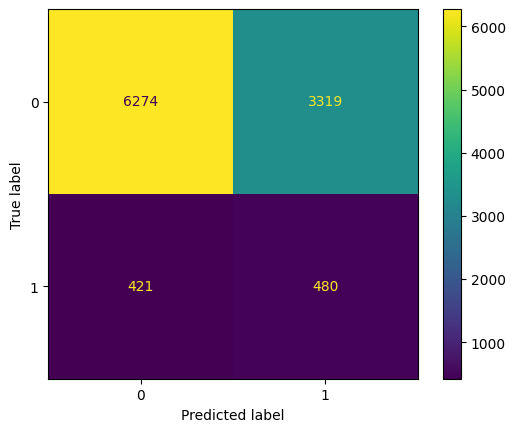

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(bagging_model, X_val_preprocessed, y_val);

In [ ]:
# Save the model to drive
filename = '/content/drive/MyDrive/bb_model.joblib'
joblib.dump(bagging_model, open(filename, 'wb'))

For class 1 (patients predicted to be readmitted), the Bagging model demonstrates a precision of `0.13`, indicating a low rate of correct positive predictions. However, with a recall of `0.53`, the model identifies over half of the actual readmitted patients, performing better than the other trained models.

Despite this improvement in recall, the F1-score remains low at `0.20`, reflecting an imbalance between precision and recall. Overall, while the model has some success in identifying readmitted patients, its ability to make accurate predictions for class 1 is limited.


# Comparing the models

In [42]:
# Logistic Regression classification report
report_lr = classification_report(y_val, y_pred_lr, output_dict=True)
# Random Forest classification report
report_rf = classification_report(y_val, y_pred_rf, output_dict=True)
# XGBoost classification report
report_xgb = classification_report(y_val, y_pred_xgb, output_dict=True)
# Catboost classification report
report_cat = classification_report(y_val, y_pred_cat, output_dict=True)
# hybrid modelclassification report
report_bag = classification_report(y_val, y_pred_bag, output_dict=True)

# Create a DataFrame to compare precision, recall, and F1-score for class 0 and 1 across all models
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Catboost', 'Balanced-Bagging model'],
    'Accuracy': [report_lr['accuracy'], report_rf['accuracy'],
                 report_xgb['accuracy'], report_cat['accuracy'],
                 report_bag['accuracy']],
    'Precision (Class 0)': [report_lr['0']['precision'], report_rf['0']['precision'],
                            report_xgb['0']['precision'], report_cat['0']['precision'],
                            report_bag['0']['precision']],
    'Precision (Class 1)': [report_lr['1']['precision'], report_rf['1']['precision'],
                            report_xgb['1']['precision'], report_cat['1']['precision'],
                            report_bag['1']['precision']],
    'Recall (Class 0)': [report_lr['0']['recall'], report_rf['0']['recall'],
                         report_xgb['0']['recall'], report_cat['0']['recall'],
                         report_bag['0']['recall']],
    'Recall (Class 1)': [report_lr['1']['recall'], report_rf['1']['recall'],
                         report_xgb['1']['recall'], report_cat['1']['recall'],
                         report_bag['1']['recall']],
    'F1-Score (Class 0)': [report_lr['0']['f1-score'], report_rf['0']['f1-score'],
                           report_xgb['0']['f1-score'], report_cat['0']['f1-score'],
                           report_bag['0']['f1-score']],
    'F1-Score (Class 1)': [report_lr['1']['f1-score'], report_rf['1']['f1-score'],
                           report_xgb['1']['f1-score'], report_cat['1']['f1-score'],
                           report_bag['1']['f1-score']]
})

# Set the 'Model' column as the index
comparison_df.set_index('Model', inplace=True)

# Round the values to 2 decimal places
comparison_df = comparison_df.round(2)

# Display the table
comparison_df

,Accuracy,Precision (Class 0),Precision (Class 1),Recall (Class 0),Recall (Class 1),F1-Score (Class 0),F1-Score (Class 1)
Model,,,,,,,
Logistic Regression,0.66,0.94,0.13,0.68,0.50,0.79,0.20
Random Forest,0.75,0.93,0.14,0.78,0.40,0.85,0.21
XGBoost,0.67,0.94,0.13,0.69,0.50,0.79,0.21
Catboost,0.66,0.94,0.13,0.68,0.50,0.79,0.20
Balanced-Bagging model,0.64,0.94,0.13,0.65,0.53,0.77,0.20


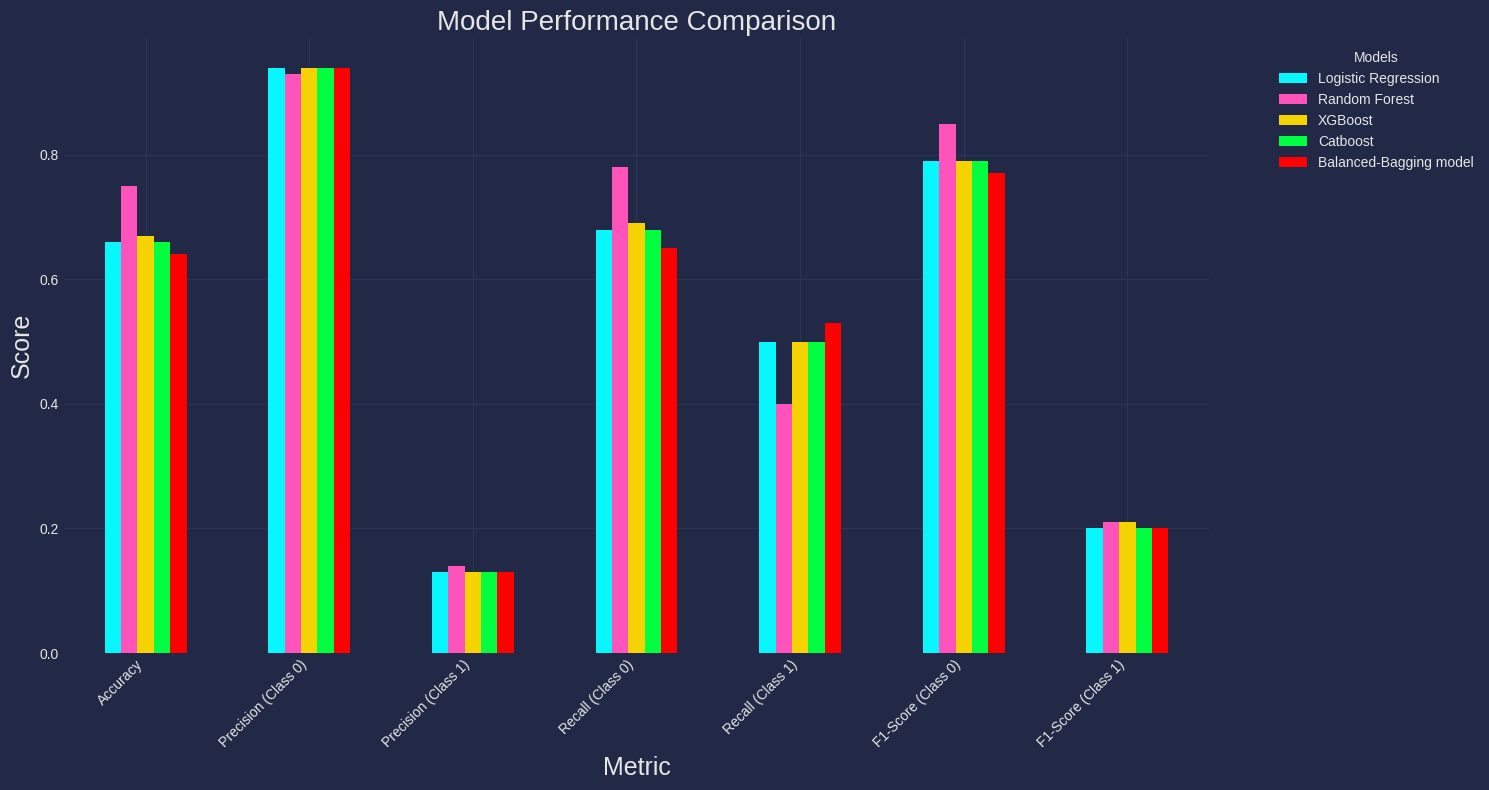

In [46]:
# Transpose the DataFrame for easier plotting
comparison_df_t = comparison_df.T

# Create a clustered bar chart
ax = comparison_df_t.plot(kind='bar', figsize=(15, 8))

# Customize the chart
plt.title('Model Performance Comparison',  size=20)
plt.xlabel('Metric',  size=18)
plt.ylabel('Score',  size=18)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

> Let's take a closer look at the precison and recall scores of the models for class 1 (readmission).

In [52]:
import plotly.graph_objects as go

# Create lists for the models and corresponding precision and recall values
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Catboost', 'Balanced-Bagging model']
precision_class_1 = [0.13, 0.14, 0.13, 0.13, 0.13]
recall_class_1 = [0.50, 0.40, 0.50, 0.50, 0.53]

# Create subplots for precision and recall
fig = go.Figure()

# Precision Class 1
fig.add_trace(go.Bar(
    x=models,
    y=precision_class_1,
    name='Precision (Class 1)',
    marker_color='lightblue'
))

# Recall Class 1
fig.add_trace(go.Bar(
    x=models,
    y=recall_class_1,
    name='Recall (Class 1)',
    marker_color='lightgreen'
))

# Customize the layout
fig.update_layout(
    title="Precision and Recall for Class 1 across Models",
    xaxis_title="Models",
    yaxis_title="Score",
    barmode='group',
    template='plotly_dark',
    font_color= '#D3D3D3',
    xaxis_gridcolor='#333333',
    yaxis_gridcolor='#333333',
)

# Show the figure
fig.show()

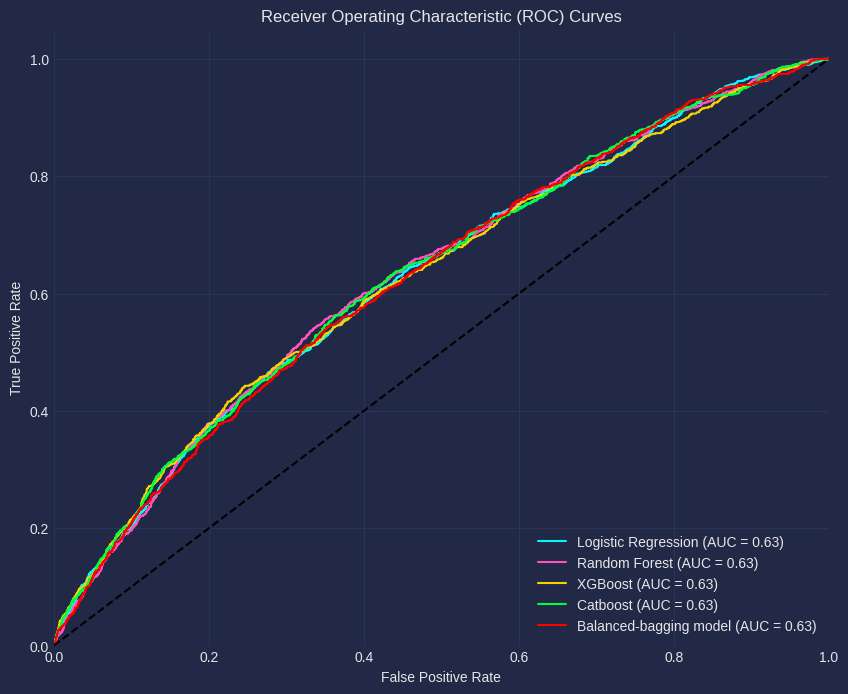

In [53]:
# Compute ROC curve and ROC area for each model
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_cat, tpr_cat, _ = roc_curve(y_val, y_pred_proba_cat)
roc_auc_cat = auc(fpr_cat, tpr_cat)

fpr_bag, tpr_bag, _ = roc_curve(y_val, y_pred_proba_bag)
roc_auc_bag = auc(fpr_bag, tpr_bag)


# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_cat, tpr_cat, label=f'Catboost (AUC = {roc_auc_cat:.2f})')
plt.plot(fpr_bag, tpr_bag, label=f'Balanced-bagging model (AUC = {roc_auc_bag:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

### AUC-ROC Comparison of Models
The plot above displays the Receiver Operating Characteristic (ROC) curves for the five models: **Logistic Regression, Random Forest, XGBoost, CatBoost, and a Balanced-Bagging classifier**. The Area Under the Curve (AUC) for all the models is `0.63`, indicating that none of the models are performing particularly well in distinguishing between the positive class (readmission) and the negative class (non-readmission).

AUC values closer to 0.5 suggest that the models are only slightly better than random guessing, and all models fall within this range, showing a `moderate` level of prediction power. Additionally, the ROC curves of all models are almost identical, indicating that they are encountering similar challenges in distinguishing between the two classes.

Despite tuning, further improvements, such as enhancing feature engineering or applying more advanced balancing techniques, may be necessary to boost model performance, especially when it comes to predicting the minority class (readmission).

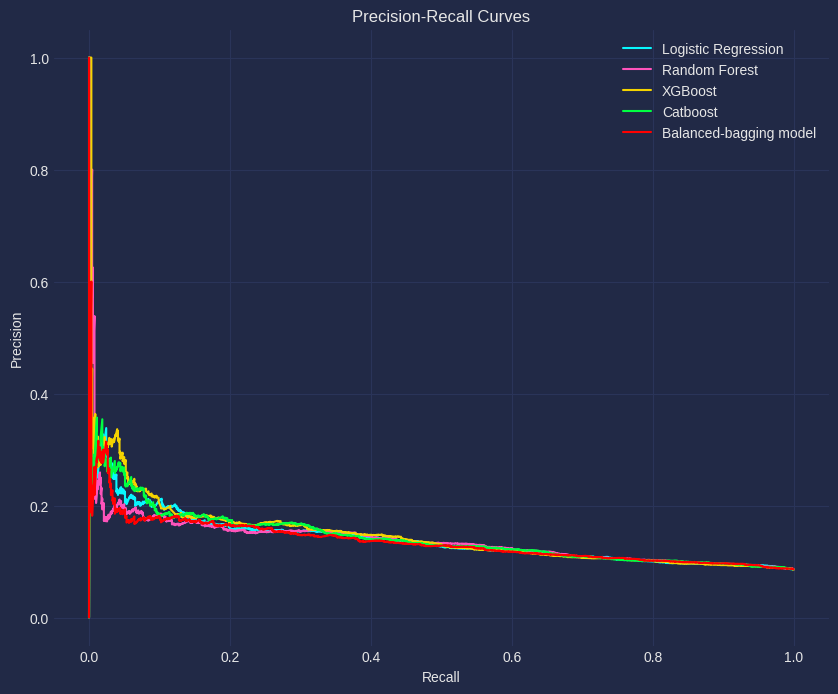

In [54]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curve for each model
precision_lr, recall_lr, _ = precision_recall_curve(y_val, y_pred_proba_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_val, y_pred_proba_rf)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_val, y_pred_proba_xgb)
precision_cat, recall_cat, _ = precision_recall_curve(y_val, y_pred_proba_cat)
precision_bag, recall_bag, _ = precision_recall_curve(y_val, y_pred_proba_bag)

# Plot all Precision-Recall curves
plt.figure(figsize=(10, 8))
plt.plot(recall_lr, precision_lr, label='Logistic Regression')
plt.plot(recall_rf, precision_rf, label='Random Forest')
plt.plot(recall_xgb, precision_xgb, label='XGBoost')
plt.plot(recall_cat, precision_cat, label='Catboost')
plt.plot(recall_bag, precision_bag, label='Balanced-bagging model')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="upper right")
plt.show()

### Precision-Recall Curve Summary
The Precision-Recall curve shown above compares the performance of the models — **Logistic Regression, Random Forest, XGBoost, CatBoost, and Balanced-Bagging** — in predicting readmissions (Class 1). This type of curve is especially useful for imbalanced datasets, as it focuses on the positive class's performance.

Key observations:

- All models show a sharp drop in precision after a low recall value, indicating that most models struggle to maintain precision when increasing recall.
- Precision generally remains low across the models, highlighting the challenge in accurately identifying positive cases without also misclassifying many negatives.
- Similar to the **AUC-ROC** curve, all models appear to perform similarly in terms of precision and recall, suggesting room for improvement, particularly in balancing precision and recall for minority class predictions.
- This reinforces the earlier observation that none of the models are especially effective at distinguishing the minority class, which may require further investigation into model optimization or data balancing techniques.

# `Balanced-bagging` is the Best Model for Predicting Readmission.

The Balanced-Bagging model provides the highest **Recall** (`0.53`) for predicting readmission (Class 1). This means it is the most effective at identifying patients who are likely to be readmitted. Although its **Precision** (`0.13`) is not very high, the primary concern in this case is maximizing the detection of readmission events, which is more critical for ensuring timely interventions and care.

The slightly higher **Recall** compared to other models makes Balanced-Bagging the best choice for predicting readmission, as it minimizes the number of false negatives (missed readmissions). This model is therefore most suitable for situations where identifying as many true readmissions as possible is a priority, even at the cost of lower precision.


In [ ]:
# using balanced bagging to make final predictions on the test set
y_pred = bagging_model.predict(X_test_preprocessed)
y_pred_proba = bagging_model.predict_proba(X_test_preprocessed)[:, 1]

In [ ]:
# Print classification report
print("Classification Report: ")
print(classification_report(y_test, y_pred))

Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.66      0.77      9563
           1       0.14      0.56      0.22       931

    accuracy                           0.65     10494
   macro avg       0.54      0.61      0.50     10494
weighted avg       0.87      0.65      0.73     10494



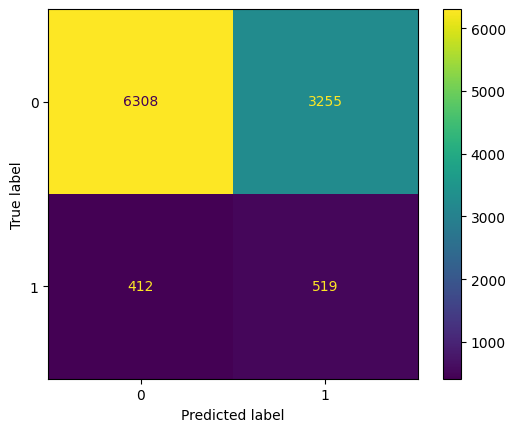

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(bagging_model, X_test_preprocessed, y_test);

In [ ]:
readmission_probabilities = y_pred_proba

# Print some probabilities for demonstration
for i in range(5):
    print(f"Patient {i} has {readmission_probabilities[i]:.2%} chance of being readmitted")

Patient 0 has 42.97% chance of being readmitted
Patient 1 has 48.35% chance of being readmitted
Patient 2 has 38.36% chance of being readmitted
Patient 3 has 39.14% chance of being readmitted
Patient 4 has 68.42% chance of being readmitted


# Feature Importances_
Getting imporant features using the logistic regressor model. This is because the log reg model is the estimator for our chosen balanced bagging model.

In [57]:
# Get the best estimator (fitted Logistic Regression model) from GridSearchCV
best_log_reg_model = logistic_regressor.best_estimator_

# Extract the coefficients (feature importances)
coefs = best_log_reg_model.coef_[0]

# Create a DataFrame to display feature importances
feature_importance_df_log_reg = pd.DataFrame({
    'Feature': X_train_preprocessed.columns,
    'Importance': np.abs(coefs)  # Take absolute values for importance
})

# Sort the DataFrame by importance in descending order
feature_importance_df_log_reg = feature_importance_df_log_reg.sort_values('Importance', ascending=False)

# Display the top 10 features
print("Top 15 Feature Importances for Logistic Regression:")
print(feature_importance_df_log_reg.head(15))

Top 15 Feature Importances for Logistic Regression:
                                              Feature  Importance
32                         discharge_disposition_Home    0.489690
7                                    number_inpatient    0.364229
34  discharge_disposition_Transfer to another faci...    0.183352
46                      primary_diagnosis_Respiratory    0.174362
17                                        diabetesMed    0.169825
25                                        age_[50-60]    0.132891
23                                         age_[0-40]    0.104794
6                                    number_emergency    0.103276
36                             admission_source_Other    0.083147
48                                         insulin_No    0.077889
38                      primary_diagnosis_Circulatory    0.077508
49                                     insulin_Steady    0.063774
43                  primary_diagnosis_Musculoskeletal    0.063661
11                      

In [60]:
import plotly.express as px

top_10_features = feature_importance_df_log_reg.head(10)

# Create a bar chart using Plotly Express
fig = px.bar(
    top_10_features[::-1],
    x="Importance",
    y="Feature",
    orientation="h",
    title="Top 10 Feature Importances for Logistic Regression",
    labels={"Importance": "Feature Importance"},
)

# Customize the bar chart
fig.update_layout(
    xaxis_title="Feature Importance",
    yaxis_title="Feature",
    font=dict(size=12),
    template="plotly_dark"
)

fig.show()

The features above were identified as the most influential in predicting the likelihood of readmission among diabetes patients. The importance values reflect how much each feature contributes to the prediction model. Below is an explanation of these features:

- Discharge Disposition (Home)

Patients discharged to their homes have the highest positive influence on reducing the likelihood of readmission. This indicates that home recovery may lead to fewer complications or better follow-up care, reducing the need for readmission.

- Number of Inpatient Visits

The number of prior inpatient admissions is a strong indicator for predicting readmission. Patients with more inpatient visits are more likely to be readmitted, potentially due to recurring or uncontrolled conditions.

- Discharge Disposition (Transfer to Another Facility)

Transfers to other facilities (e.g., skilled nursing or rehabilitation center) increase the likelihood of readmission. This may be due to underlying complications that require specialized care, leading to a higher risk of needing further hospitalization.

- Primary Diagnosis (Respiratory)

A primary diagnosis related to respiratory conditions correlates with higher readmission rates. Chronic respiratory diseases may require ongoing monitoring and lead to frequent hospitalizations in diabetic patients.

- Diabetes Medication Use

Whether a patient is taking diabetes medication (e.g., metformin or insulin) significantly affects readmission risk. Patients actively managing their diabetes through medication may experience fewer complications, although non-adherence could raise the risk of readmission.

- Age Group (50-60 Years)

Patients between the ages of 50 and 60 show a higher likelihood of readmission, possibly because of age-related complications that make managing diabetes more challenging.

- Age Group (0-40 Years)

Younger patients also have an increased readmission risk, though to a lesser extent than the 50-60 age group. This could be linked to difficulties in maintaining long-term diabetes management, even at younger ages.

- Number of Emergency Visits

A history of frequent emergency visits indicates a higher risk of future readmissions, as it suggests poor control of diabetes or related conditions.

- Admission Source (Other)

Admission sources other than home or typical care settings (e.g., clinics) indicate an elevated risk of readmission. This suggests that patients admitted through less conventional sources may face unique challenges in managing their conditions.

- Insulin Use (No)

Patients who are not on insulin have a slightly higher likelihood of readmission compared to those using insulin. This suggests that insulin use plays an important role in maintaining stable blood glucose levels and avoiding complications that might lead to hospitalization in diabetes patients.

> Overall, these features highlight a combination of discharge planning, age, prior hospital admissions, and primary diagnoses as significant factors in predicting the risk of readmission among diabetic patients. Effective post-discharge care, particularly for patients with respiratory issues or those with frequent inpatient/emergency visits, may reduce the risk of readmission.